# The Simple Harmonic Oscillator

In this notebook, we will go through implementing the simple harmonic system for which we'll train a neural network to learn to control the oscillator state.

We will train a separate network to learn the system dynamics as well. 

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import warnings
import torch
import neuralode

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cuda')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float32)

In [3]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = (torch.ones_like(initial_position))
damping = (torch.ones_like(initial_position)*0.25)
initial_state = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1).requires_grad_(True)

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(25.0)

initial_timestep = (final_time - initial_time) / 100

current_integrator = neuralode.integrators.AdaptiveRK76Integrator

atol = rtol = torch.tensor(1e-7)

In [4]:
final_state, _, sha_states, sha_times, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, damping)

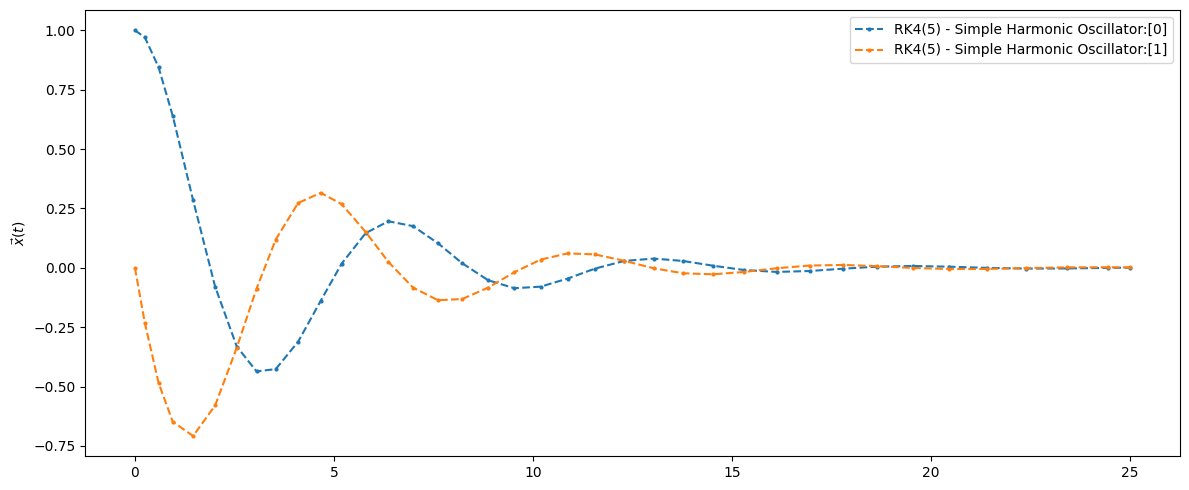

In [5]:
fig, axes = neuralode.plot.trajectory.plot_trajectory([(i, j) for i, j in zip(sha_states, sha_times)], method_label="RK4(5) - Simple Harmonic Oscillator")

In [6]:
# Generate reference trajectory for optimisation/learning
with torch.no_grad():
    _, _, sha_states_ref, sha_times_ref, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, {'atol': torch.zeros_like(atol), 'rtol': rtol}, frequency, damping)
sha_states_ref, sha_times_ref = sha_states_ref.detach(), sha_times_ref.detach()

In [7]:
state_dataset = sha_states_ref[1:].clone()
time_dataset  = sha_times_ref[1:].clone()

# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class OscillatorNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        if x.dim() == 1:
            return self.internal_net(x[None])[0]
        else:
            return self.internal_net(x)

# Here we instantiate our network.
simple_oscillator_net = OscillatorNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        torch.nn.init.normal_(m.weight, mean=-0.1, std=0.1)
        if m.bias is not None:
            m.bias.data.normal_(0.0, 0.01)
simple_oscillator_net.apply(init_weights)

# `torch.autograd.Function`s track computation on all input tensors.
# For that reason, we must pass our neural network parameters to the integrator,
# which will pass it to the derivative function.
# Since our network is stateful, we don't use these parameters, but define them in 
# the function signature.
def sha_nn_fn(x, t, *nn_parameters):
    return simple_oscillator_net(x, t)

optimiser = torch.optim.Adam(simple_oscillator_net.parameters(), lr=1e-1, amsgrad=True)
# Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=16)

def sha_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        current_state, current_time, _, _, _ = current_integrator.apply(sha_nn_fn, current_state, current_time, sample_time, dt, {'atol': atol, 'rtol': rtol}, *simple_oscillator_net.parameters())
        error = error + (sample_state - current_state).square().mean()
    if error.requires_grad:
        error.backward()
    return error

ideal_matrix = neuralode.dynamics.get_simple_harmonic_oscillator_matrix(frequency, damping)
ideal_bias = torch.zeros_like(initial_state)

batch_size = 8

# Now we need an optimisation `loop` where we will take steps to minimise the error. 
# We don't know how many steps are required to "train" this network, so we start with a large number
number_of_gd_steps = 1024

best_error = torch.inf
# For pytorch modules, the `state_dict` method allows us to get a copy
# of all the parameters that define the model, thus enabling us to 
# store the state as well as restore it.
best_parameters = simple_oscillator_net.state_dict()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*state_dataset.shape[0]
        # print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f} ", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = simple_oscillator_net.state_dict()
    lr_on_plateau.step(epoch_error)
    learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
    learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']
    # Ideally our matrix is equivalent to our simple harmonic oscillator matrix and our bias goes to zero
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, \nW={learned_matrix.cpu()}, \nb={learned_bias.cpu()}")
    print()
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6 or best_error < 1e-4:
        break
    
simple_oscillator_net.load_state_dict(best_parameters)
learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']

# Before we were looking at relative error, but in the case of a matrix with zeros,
# the relative error is undefined, so we look at another common metric: mean absolute error
print(f"Best matrix: {learned_matrix}, mean absolute error: {torch.mean(torch.abs(ideal_matrix - learned_matrix)).item():.6f}")
print(f"Best bias:   {learned_bias}, mean absolute error: {torch.mean(torch.abs(ideal_bias - learned_bias)).item():.6f}")

[1/1024] Epoch Error: 7.983238, 
W=tensor([[-0.5982, -0.3809],
        [ 0.4806, -0.5125]]), 
b=tensor([ 0.0418, -0.1843])

[2/1024] Epoch Error: 4.341687, 
W=tensor([[-0.8153, -0.4902],
        [ 0.6366, -0.7843]]), 
b=tensor([ 0.0897, -0.1999])

[3/1024] Epoch Error: 3.268306, 
W=tensor([[-0.9304, -0.4980],
        [ 0.7180, -0.9633]]), 
b=tensor([ 0.0404, -0.1185])

[4/1024] Epoch Error: 2.697661, 
W=tensor([[-0.9906, -0.5182],
        [ 0.7492, -1.0755]]), 
b=tensor([-0.0133, -0.0454])

[5/1024] Epoch Error: 2.575682, 
W=tensor([[-1.0245, -0.5809],
        [ 0.7484, -1.1529]]), 
b=tensor([-0.0508, -0.0176])

[6/1024] Epoch Error: 2.551354, 
W=tensor([[-1.0407, -0.6323],
        [ 0.7312, -1.2073]]), 
b=tensor([-0.0413, -0.0112])

[7/1024] Epoch Error: 2.492288, 
W=tensor([[-1.0522, -0.7062],
        [ 0.7063, -1.2568]]), 
b=tensor([-0.0444, -0.0255])

[8/1024] Epoch Error: 2.429760, 
W=tensor([[-1.0580, -0.7629],
        [ 0.6782, -1.2988]]), 
b=tensor([-0.0326, -0.0407])

[9/1024]

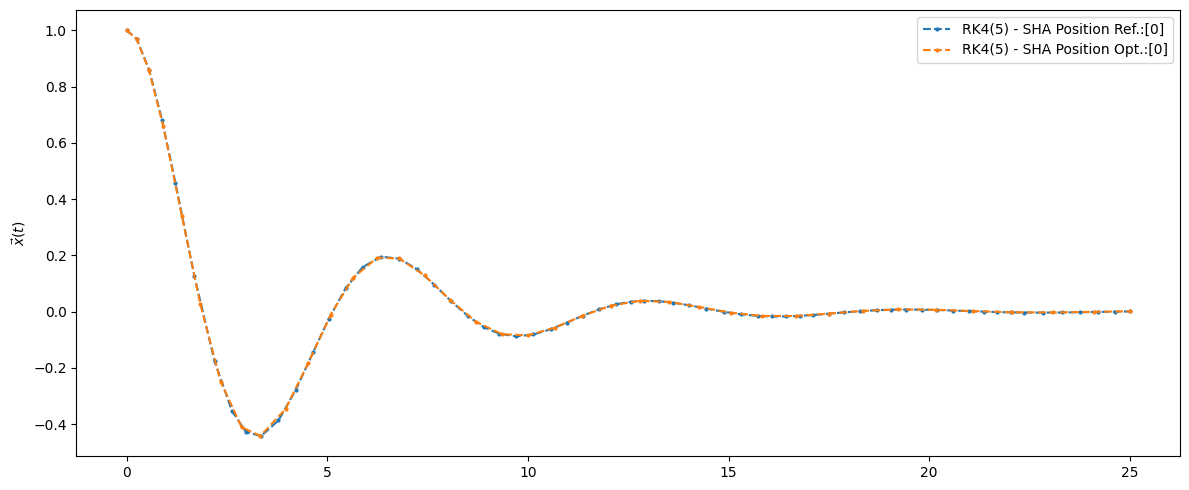

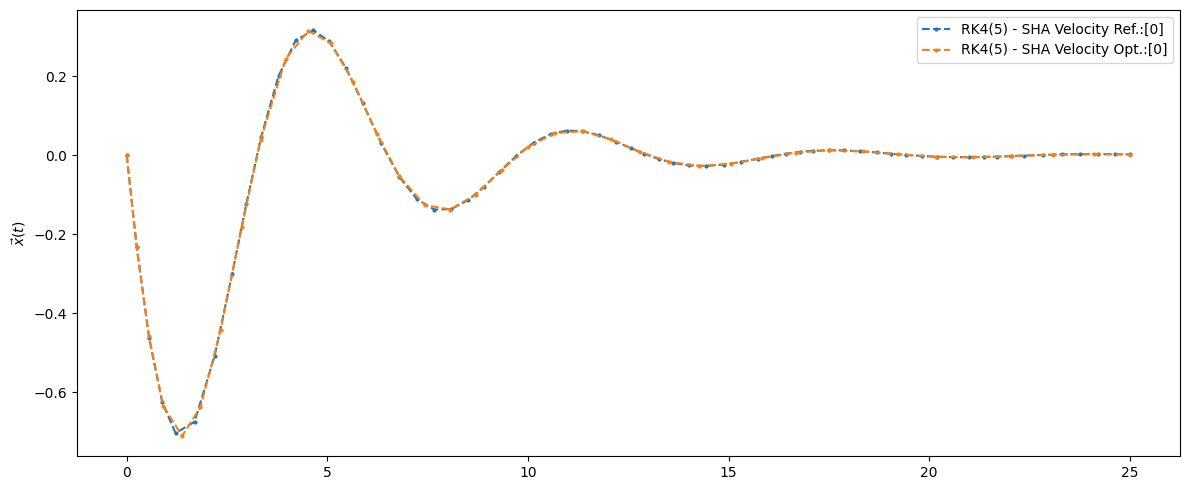

In [8]:
simple_oscillator_net.load_state_dict(best_parameters)
simple_oscillator_net.eval()

fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = current_integrator.apply(sha_nn_fn, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol})

_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

This replicates the prior results, so let's incorporate control of the oscillator. We'll be using the forced harmonic oscillator model where we not only have movement of the oscillator with the dynamics that come from the simple harmonic oscillator but also a driving force that does work on the system.

Mathematically, this is equivalent to  

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = 
\mathbf{A}
\begin{bmatrix}
    x \\
    v
\end{bmatrix} + 
\begin{bmatrix}
    0 \\
    F
\end{bmatrix}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
    0 & 1 \\
    -\omega^2 & -2\zeta\omega
\end{bmatrix}
$$

If we were to learn both the dynamics and the driving force together, we'd need both driven and undriven oscillator states as the two networks could learn some kind of combined dynamics that integrates the driving force into the RHS. In that fashion, we'd no longer be able to distinguish the dynamics of the oscillator itself from the driving force.

In [9]:
state_range_min = torch.tensor([-25.0, -5.0])
state_range_max = torch.tensor([ 25.0,  5.0])

state_dataset = torch.rand(32, 2) * (state_range_max - state_range_min)[None] + state_range_min[None]

# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class DrivenOscillatorNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 2),
            torch.nn.ReLU(),
        )
    
    def forward(self, x, t):
        if x.dim() == 1:
            return self.internal_net(x[None])[0]
        else:
            return self.internal_net(x)

driven_oscillator_net = DrivenOscillatorNet()
driven_oscillator_net.apply(init_weights)
max_acceleration = torch.tensor(25.0)

def dha_nn_fn(x, t, frequency, damping, *nn_parameters):
    control_u = (driven_oscillator_net(x, t)*2 - 1)*max_acceleration
    return neuralode.dynamics.simple_harmonic_oscillator(x, t, frequency, damping) + control_u.clamp(min=-max_acceleration, max=max_acceleration)

optimiser = torch.optim.Adam(driven_oscillator_net.parameters(), lr=1e-2, amsgrad=True)
# Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser)

def dha_closure(minibatch):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    _, _, intermediate_states, intermediate_times, _ = current_integrator.apply(dha_nn_fn, states, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, torch.zeros_like(damping), *driven_oscillator_net.parameters())
    
    # Simple rectangle method integral of the square error.
    error = (intermediate_states[1:,...,1].square()*intermediate_times.detach().diff(dim=-1)[:,None]).sum(dim=0).mean()
    
    if error.requires_grad:
        error.backward()
    return error

batch_size = 32

# Now we need an optimisation `loop` where we will take steps to minimise the error. 
# We don't know how many steps are required to "train" this network, so we start with a large number
number_of_gd_steps = 1024

best_error = torch.inf
# For pytorch modules, the `state_dict` method allows us to get a copy
# of all the parameters that define the model, thus enabling us to 
# store the state as well as restore it.
best_parameters = driven_oscillator_net.state_dict()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: dha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*state_dataset.shape[0]
        # print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f} ", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = driven_oscillator_net.state_dict()
    lr_on_plateau.step(epoch_error)
    # Ideally our matrix is equivalent to our simple harmonic oscillator matrix and our bias goes to zero
    print(f"[{step+1}/{number_of_gd_steps} - {lr_on_plateau.get_last_lr()[0]}] Epoch Error: {epoch_error:.6f}")
    print()
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break
    
driven_oscillator_net.load_state_dict(best_parameters)

[1/1024 - 0.01] Epoch Error: 34816.929688

[2/1024 - 0.01] Epoch Error: 33272.625000

[3/1024 - 0.01] Epoch Error: 31976.789062

[4/1024 - 0.01] Epoch Error: 30011.281250

[5/1024 - 0.01] Epoch Error: 28584.691406

[6/1024 - 0.01] Epoch Error: 27132.695312

[7/1024 - 0.01] Epoch Error: 25727.015625

[8/1024 - 0.01] Epoch Error: 24395.781250

[9/1024 - 0.01] Epoch Error: 23171.962891

[10/1024 - 0.01] Epoch Error: 22188.126953

[11/1024 - 0.01] Epoch Error: 21247.578125

[12/1024 - 0.01] Epoch Error: 20398.171875

[13/1024 - 0.01] Epoch Error: 19798.802734

[14/1024 - 0.01] Epoch Error: 19304.886719

[15/1024 - 0.01] Epoch Error: 19101.166016

[16/1024 - 0.01] Epoch Error: 18988.689453

[17/1024 - 0.01] Epoch Error: 18643.242188

[18/1024 - 0.01] Epoch Error: 18314.550781

[19/1024 - 0.01] Epoch Error: 17946.859375

[20/1024 - 0.01] Epoch Error: 17803.167969

[21/1024 - 0.01] Epoch Error: 17715.855469

[22/1024 - 0.01] Epoch Error: 17664.585938

[23/1024 - 0.01] Epoch Error: 17557.95312

<All keys matched successfully>

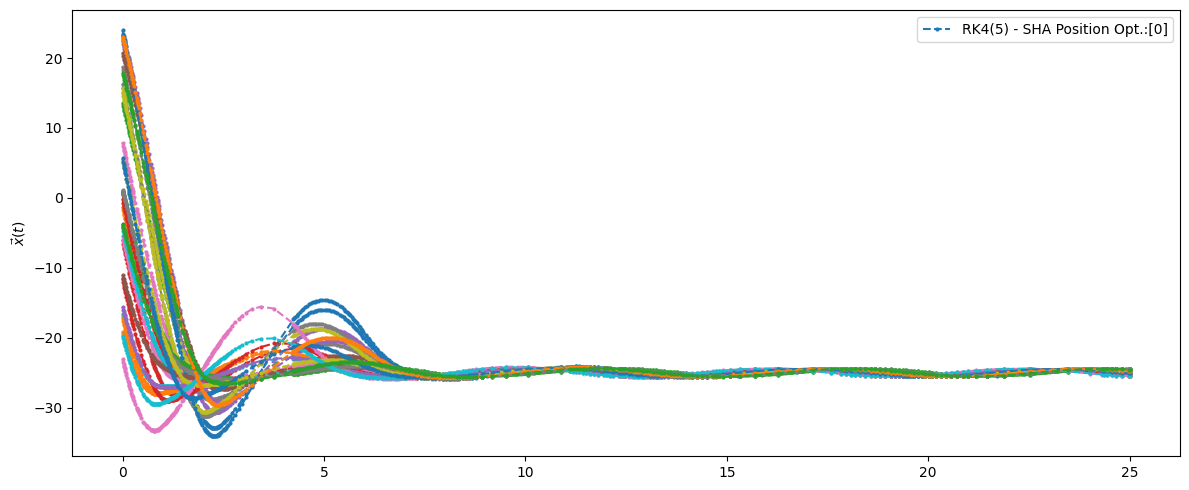

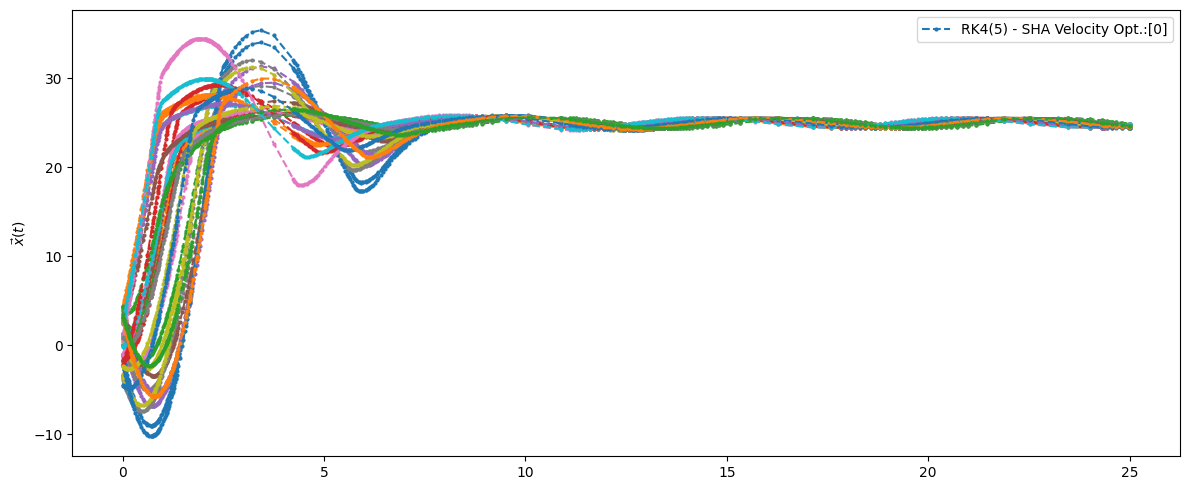

In [10]:
driven_oscillator_net.load_state_dict(best_parameters)
driven_oscillator_net.eval()
_, _, dha_states_optimised, dha_times_optimised, _ = current_integrator.apply(dha_nn_fn, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, torch.zeros_like(damping))

fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label="RK4(5) - SHA Position Opt.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label="RK4(5) - SHA Velocity Opt.")

_, _, dha_states_dataset, dha_times_dataset, _ = current_integrator.apply(dha_nn_fn, state_dataset, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, torch.zeros_like(damping))

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(dha_states_dataset, dha_times_dataset)], axes=axes_ref_position, method_label=None)
_ = neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(dha_states_dataset, dha_times_dataset)], axes=axes_ref_velocity, method_label=None)

Here we can see that the network has learned how to dampen the oscillations of the system and nudge it towards zero at the end of the trajectory